<a href="https://colab.research.google.com/github/sunilvengalil/concept_learning/blob/master/notebooks/classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.40.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.40.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
from google.colab import drive

In [3]:
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [41]:
!mv "/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/semi_supervised_experiments/semi_supervised_classification.zip (Unzipped Files)/semi_supervised_classification" /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/

In [42]:
!ls /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/

datasets      semi_supervised_classification	       semi_sup_gaussian_mah_k5
Experiment_3  semi_supervised_classification_gaussian  semi_sup_gaussian_mah_k8
Experiment_5  semi_supervised_experiments
Experiment_7  semi_sup_gaussian_mah_k10


In [6]:
cd semi_supervised_experiments/

/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/semi_supervised_experiments


In [7]:
!ls

 semi_supervised_classification_gaussian.zip
 semi_supervised_classification_only_correct_label.zip
 semi_supervised_classification_published.zip
 semi_supervised_classification.zip
 semi_supervised_random.zip
 semi_sup_gaussian_mah_k10.zip
'semi_sup_gaussian_mah_k10.zip (Unzipped Files)'
 semi_sup_gaussian_mah_k5.zip
 semi_sup_gaussian_mah_k8.zip
 semi_sup_gaussian_mah.zip


In [4]:
%cd /content/gdrive/MyDrive/concept_learning/concept_learning

/content/gdrive/MyDrive/concept_learning/concept_learning


In [12]:
!git checkout .
!git checkout master

Checking out files: 100% (9/9), done.
M	app/backend/app/alembic.ini
M	app/backend/app/alembic/README
M	app/backend/app/alembic/env.py
M	app/backend/app/alembic/script.py.mako
M	app/backend/app/alembic/versions/.keep
M	app/backend/app/app/models/item.py
M	app/backend/app/app/models/user.py
M	app/backend/app/app/tests/.gitignore
M	app/backend/app/scripts/format-imports.sh
M	app/backend/app/scripts/format.sh
M	app/backend/app/scripts/init_db.sh
M	app/backend/app/scripts/reset_db.sh
M	app/backend/app/scripts/test-cov-html.sh
M	app/backend/app/scripts/test.sh
M	app/frontend/.dockerignore
Previous HEAD position was 30e406f Created using Colaboratory
Switched to branch 'master'
Your branch is up to date with 'origin/master'.


In [17]:
!git pull

remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Total 171 (delta 50), reused 50 (delta 50), pack-reused 121
Receiving objects: 100% (171/171), 31.08 MiB | 8.59 MiB/s, done.
Resolving deltas: 100% (120/120), completed with 25 local objects.
From https://github.com/sunilvengalil/concept_learning
   a4890b8..fd948e7  master     -> origin/master
Updating a4890b8..fd948e7
Checking out files: 100% (52/52), done.
Fast-forward
 cifar_10_experiments/experiment_7.ipynb            |  6177 +++++++
 clearn/analysis/annotate_multiple.py               |    14 +-
 clearn/analysis/cluster_utils.py                   |   229 +-
 clearn/config/__init__.py                          |     4 +
 clearn/dao/cifar_10.py                             |    29 +-
 clearn/dao/dao_factory.py                          |     4 +-
 clearn/experiments/experiment.py                   |    90 +-
 clearn/models/classify/cifar_10_classifier.py      |    14 +-
 clearn/models/classify/

In [5]:
#import os
from typing import List, DefaultDict
from collections import defaultdict
import pandas as pd
import numpy as np
from  scipy.signal import correlate2d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
#from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import accuracy_score

# from numpy.linalg import norm
# import matplotlib
from matplotlib import pyplot as plt
from clearn.experiments.experiment import Experiment, load_trained_model, get_model, get_train_val_iterator, MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
from clearn.dao.dao_factory import get_dao

import tensorflow as tf
from clearn.utils.data_loader import TrainValDataIterator, DataIterator
from clearn.utils.data_loader import load_images
#from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config.common_path import get_encoded_csv_file
from clearn.models.classify.classifier import ClassifierModel
from clearn.config import ExperimentConfig
#from clearn.analysis.cluster_utils import plot_features, trace_dim
from matplotlib import pyplot  as  plt
from scipy.special import softmax

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
root_path="/content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp"

In [7]:
def classify_images(model, images, batch_size, z_dim):
    num_images = images.shape[0]
    num_batches = num_images // batch_size
    batch_num = 0
    logits = np.zeros([len(images), z_dim])
    print(logits.shape)
    print(logits[batch_num * batch_size: (batch_num + 1) * batch_size].shape)
    if num_batches >= 1:
        # Run for first batch to get the dimensions
        batch_num = 0
        _logits = model.classify(images[batch_num * batch_size: (batch_num + 1) * batch_size])[0]
        print(_logits.shape)
        logits[batch_num * batch_size: (batch_num + 1) * batch_size] = _logits
 
        for batch_num in range(1, num_batches):
            _logits = model.classify(images[batch_num * batch_size: (batch_num + 1) * batch_size])[0]
            logits[batch_num * batch_size: (batch_num + 1) * batch_size] = _logits
 
    left_out = num_images % batch_size
    if left_out > 0:
        # TODO remove this hard-coding
        feature_dimension = [batch_size, 28, 28, 1]
        last_batch = np.zeros(feature_dimension)
        last_batch[0:left_out] = images[num_batches * batch_size:]
        _logits = model.classify(last_batch)[0]
        logits[num_batches * batch_size:] = _logits[0:left_out]

    return logits


In [8]:
config_dict = dict()

z_dim = 10
run_id = 45
num_units=[64, 128, 32]
create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW
experiment_names = ["semi_sup_gaussian_mah_k10",
                    "semi_sup_gaussian_mah_k8",
                    "semi_sup_gaussian_mah_k5",
                    "semi_supervised_classification_gaussian",
                    "semi_supervised_classification"]
confidence_decay_factors =[10, 8, 5, 5, 5]
run_ids = [45, 45, 45, 45, 45, 45]
for experiment_name, confidence_decay_factor in zip(experiment_names, confidence_decay_factors):
  exp_config = ExperimentConfig(root_path=root_path,
                                num_decoder_layer=4,
                                z_dim=z_dim,
                                num_units=num_units,
                                num_cluster_config=num_cluster_config,
                                confidence_decay_factor=confidence_decay_factor,
                                beta=5,
                                supervise_weight=150,
                                dataset_name="mnist",
                                split_name="Split_1",
                                model_name="VAE",
                                batch_size=64,
                                eval_interval_in_epochs=1,
                                name=experiment_name,
                                num_val_samples=128,
                                total_training_samples=60000,
                                manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                                reconstruction_weight=1,
                                activation_hidden_layer="RELU",
                                activation_output_layer="SIGMOID")
  exp_config.check_and_create_directories(run_id)
  config_dict[experiment_name] = exp_config

dao = get_dao(exp_config.dataset_name, exp_config.split_name, exp_config.num_val_samples)

In [9]:
train_val_data_iterator = get_train_val_iterator(create_split=create_split,
                                                 dao= dao,
                                                 exp_config= exp_config,
                                                 num_epochs_completed=0,
                                                 split_name=exp_config.split_name)

Warning /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_45/analysis/manual_annotation_epoch_-1.0.csv path does not exist. Creating random prior with uniform distribution
Number of samples with manual annotation 0.0


In [10]:
test_data_location = exp_config.DATASET_ROOT_PATH + "/test/"
test_data_iterator = DataIterator(dataset_path=exp_config.DATASET_ROOT_PATH,
                                  batch_size=exp_config.BATCH_SIZE,
                                  dao=dao)

In [11]:
val_accuracies = dict()
test_accuracies = dict()
train_accuracies = dict()


In [12]:
test_images, test_labels, _ = load_images(exp_config,
                                          test_data_iterator,
                                          "test"
                                          )
unique_labels = test_data_iterator.get_unique_labels()
num_batches = test_images.shape[0] / exp_config.BATCH_SIZE
test_labels= np.argwhere(test_labels == 1)[:,1]

In [13]:
for experiment_name, exp_config in config_dict.items():
  tf.reset_default_graph()
  accuracy_dict = dict()
  for check_point_epochs in range(1, 5):
      with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
          model = get_model(dao = dao,
                            exp_config=exp_config,
                            model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                            num_epochs=1,
                            sess=sess,
                            test_data_iterator=None,
                            train_val_data_iterator=None,
                            check_point_epochs=check_point_epochs
                            )
          num_steps_completed = model.counter
          print("Number of steps completed={}".format(num_steps_completed))
          num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
          epochs_completed = num_steps_completed // num_batches
          print("Number of epochs completed {}".format(epochs_completed))
          logits = classify_images(model, test_images, exp_config.BATCH_SIZE, exp_config.Z_DIM)

      tf.reset_default_graph()

      pred = softmax(logits)
      print(pred.shape)
      pred_labels = np.argmax(pred,axis=1)
      print(pred_labels.shape)
      _acc = accuracy_score(test_labels, pred_labels)
      print(_acc)
      accuracy_dict[check_point_epochs] = _acc
  test_accuracies[experiment_name]= accuracy_dict
    








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.




 [*] Reading checkpoints...
num_training_samples 935
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /content/gdrive/MyDrive/concept_learning/concept_learning/concept_learning_exp/semi_sup_gaussian_mah_k10/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-936
 [*] Success to read SemiSupervisedClassifierMnist.model-936
 [*] Load SUCCESS
Number of steps completed=936
Number of epochs completed 1.0
(9984, 10)
(64, 10)
(64, 10)
(9984, 10)
(9984,)
0.09274839743589

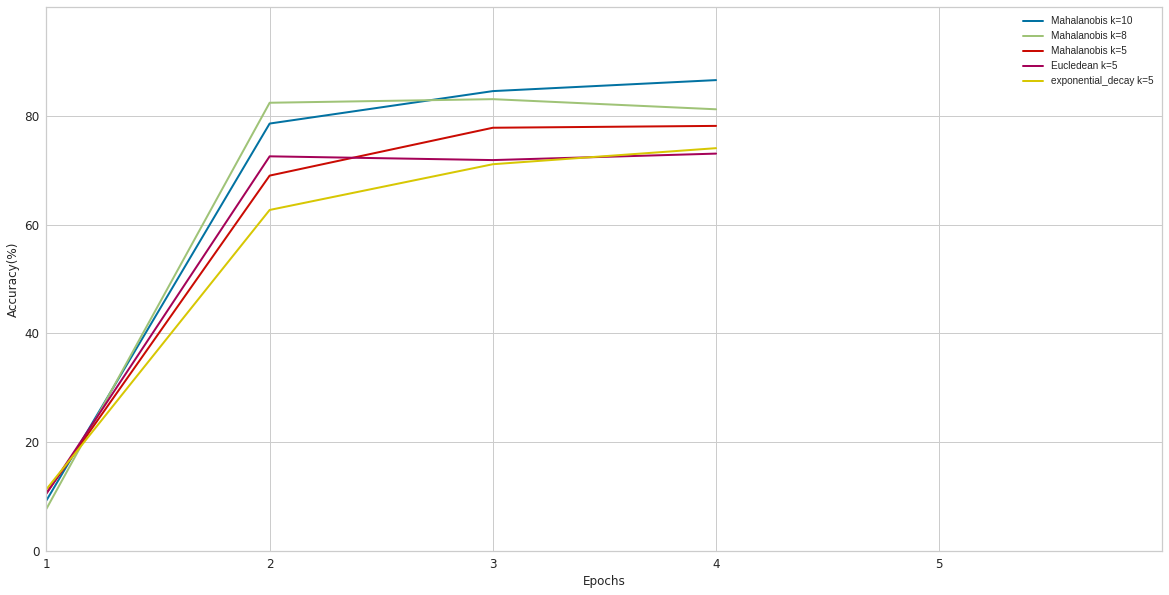

In [18]:
import os

plot_filename = "classification_accuracy.pdf"
plt.figure(figsize=(20, 10))

legends = ["Mahalanobis", "Mahalanobis", "Mahalanobis", "Eucledean", "exponential_decay"]
for confidence_decay_factor, experiment_name, legend in zip(confidence_decay_factors, experiment_names, legends):
  accuracy_dict = test_accuracies[experiment_name]
  plt.plot(list(accuracy_dict.keys()), np.asarray(list(accuracy_dict.values())) * 100, lw=2, label=f"{legend} k={confidence_decay_factor}")

axis_font = {'fontname':'Arial', 'size':'12'}

plt.xlabel("Epochs", **axis_font)
plt.ylabel("Accuracy(%)", **axis_font)

plt.xlim(1,6)
plt.xticks(ticks = [i for i in range(1,6,1)], labels = [i for i in range(1,6,1)], **axis_font)
plt.ylim(0,100)
plt.yticks(ticks=[i for i in range(0, 100, 20)], **axis_font)
plt.legend()

#plt.savefig(os.path.join("/Users/sunilv/gitprojects/concept_learning/docs/uai2021/", plot_filename), bbox="tight") 

    #plt.plot(list(accuracy_dict_unsupervised.keys()), list(accuracy_dict_unsupervised.values()))

In [15]:
drive.flush_and_unmount()

In [51]:
from google.colab import drive